In [1]:
import sys
sys.path.append("..")

from pathlib import Path

import numpy as np
import PIL
import torchvision
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from imet.dataset import load_image
from imet.transforms import train_transform

In [2]:
df_test = pd.read_csv('../data/sample_submission.csv')

In [3]:
from albumentations import *
from albumentations.pytorch.transforms import ToTensor

train_transform = Compose([
    # ShiftScaleRotate(
    #     shift_limit=0.0625, scale_limit=0.1, rotate_limit=30,
    #     border_mode=cv2.BORDER_REFLECT_101, p=1.),
    RandomScale(scale_limit=0.125),    
    Rotate(limit=10,  border_mode=cv2.BORDER_CONSTANT, value=0, p=1.),
    PadIfNeeded(350, 350, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.),    
    OneOf([
        RandomCrop(300, 300, p=0.8),
        CenterCrop(300, 300, p=0.2),
    ], p=1.),
    HorizontalFlip(p=0.5),
    # Transpose(p=0.5),
    # RandomContrast(limit=0.2, p=0.5),
    # RandomGamma(gamma_limit=(80, 120), p=0.5),
    # RandomBrightness(limit=0.2, p=0.5),
    # HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
    #                    val_shift_limit=10, p=1.),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.8),
    # OneOf([
    #     IAAAdditiveGaussianNoise(
    #         loc=0, scale=(1., 6.75), per_channel=False, p=0.3),
    #     GaussNoise(var_limit=(5.0, 20.0), p=0.6),
    # ], p=0.5),
    # Cutout(num_holes=4, max_h_size=30, max_w_size=50, p=0.75),
    # JpegCompression(quality_lower=50, quality_upper=100, p=0.5)
])

tensor_transform = ToTensor(normalize=dict(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
def plot_multi(func, r:int=1, c:int=1, figsize=(12,6)):
    "Call `func` for every combination of `r,c` on a subplot"
    axes = plt.subplots(r, c, figsize=figsize)[1]
    for i in range(r):
        for j in range(c): func(i,j,axes[i,j])

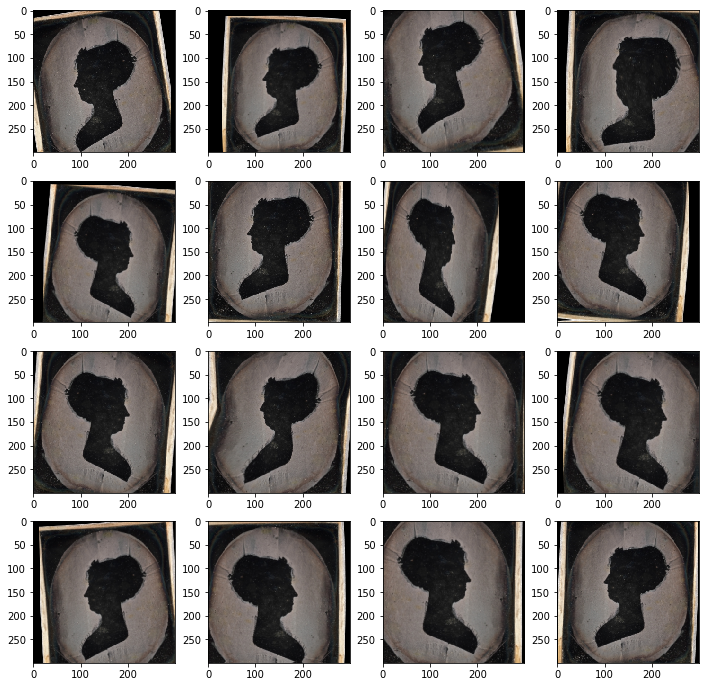

In [5]:
idx = 855
def _plot(i, j, ax):
    x= PIL.Image.fromarray(
        train_transform(image=load_image(df_test.iloc[idx], Path('../data/test/')))["image"]
    )
    ax.imshow(x)
    
plot_multi(_plot, 4, 4, figsize=(12, 12))

## MixUp

Weight 0.7365710685428735


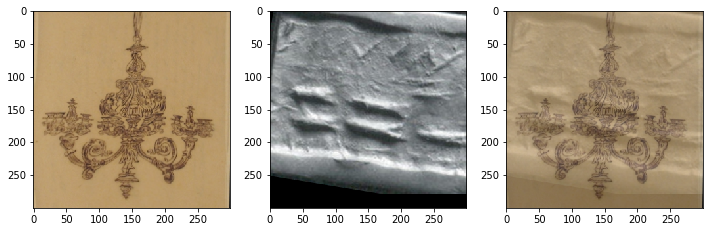

In [6]:
idx = (490, 812)
axes = plt.subplots(1, 3, figsize=(12, 4))[1]
x1 = train_transform(image=load_image(df_test.iloc[idx[0]], Path('../data/test/'),))["image"]
x2 = train_transform(image=load_image(df_test.iloc[idx[1]], Path('../data/test/'),))["image"]
axes[0].imshow(PIL.Image.fromarray(x1))
axes[1].imshow(PIL.Image.fromarray(x2))
weight = np.random.beta(1, 1)
weight = max(1-weight, weight)
print("Weight", weight)
axes[2].imshow(PIL.Image.fromarray((x1 * weight + x2 * (1-weight)).astype("uint8")))

In [7]:
" ".join(["%.4f" % x for x in np.random.beta(1, 1, 10)])

'0.3209 0.3123 0.2319 0.3004 0.1523 0.8807 0.3901 0.8712 0.2488 0.7437'

## Masking

In [10]:
idx = 201
img_arr = train_transform(image=load_image(df_test.iloc[idx], Path('../data/test/')))["image"]
tensor = tensor_transform(image=img_arr)["image"]
eps = 1e-3
zero_transformed = np.sum(np.array([0.485, 0.456, 0.406]) / np.array([0.229, 0.224, 0.225])) * -1
mask = (tensor.sum(dim=0, keepdim=True) >  zero_transformed + eps)

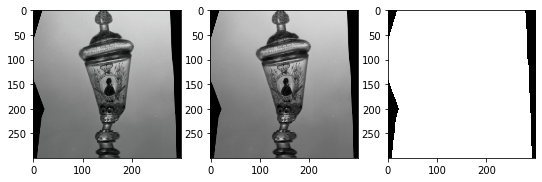

In [11]:
axes = plt.subplots(1, 3, figsize=(9,3))[1]
x= PIL.Image.fromarray(
#     train_transform(image=load_image(df_test.iloc[idx], Path('../data/test/')))["image"]
    ((tensor.numpy() * np.array([0.229, 0.224, 0.225])[:, None, None] + 
    np.array([0.485, 0.456, 0.406])[:, None, None]) * 255).astype("uint8").transpose(1, 2, 0)
)
axes[0].imshow(x)
x= PIL.Image.fromarray(
    img_arr
)
axes[1].imshow(x)
x= PIL.Image.fromarray(
    (mask.repeat(3, 1, 1).numpy() * 255).astype("uint8").transpose(1, 2, 0)
)
axes[2].imshow(x)